In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import laplace
from math import comb
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC

In [2]:
data=pd.read_csv("kaggle_data/Admission_Predict.csv")
data["Admitted"]=np.where(data["Chance of Admit"]>0.69,1,0)
data.drop(["Serial No.","Chance of Admit","SOP", "LOR", "Research"],inplace=True, axis=1)

In [3]:
def get_batch_indexes(n,data):
    vect=np.random.randint(len(data.index),size=n)
    vect=np.unique(vect)
    while (len(vect)!=n):
        vect=np.concatenate((vect,np.random.randint(len(data.index),size=n-len(vect))))
        vect=np.unique(vect)
    return np.sort(vect)

print(get_batch_indexes(20,data))

[  7  43  76 105 108 125 129 132 184 203 211 229 250 298 311 347 359 363
 371 392]


In [4]:
def sampling(data,n):
    inds=data.index
    return data.take(rd.choice(inds,n, False))

In [5]:
def get_batch(n, data):
    return data.take(get_batch_indexes(n,data))

In [6]:
def split_attr_label(data):
    dat=data.copy()
    return dat.drop("Admitted",axis=1), dat.pop("Admitted")

In [7]:
def normalize_data(data):
    n=len(data.columns)
    moy = np.zeros((n,))
    sigma = np.zeros((n,))
    for k in range(n): 
        moy[k]=np.mean(data.iloc[:, [k]])
        sigma[k] = np.std(data.iloc[:, [k]])
        data.iloc[:, [k]] = (data.iloc[:, [k]]-moy[k])/sigma[k]
    return data

In [8]:
data.loc[4:8]

,GRE Score,TOEFL Score,University Rating,CGPA,Admitted
4,314,103,2,8.21,0
5,330,115,5,9.34,1
6,321,109,3,8.20,1
7,308,101,2,7.90,0
8,302,102,1,8.00,0


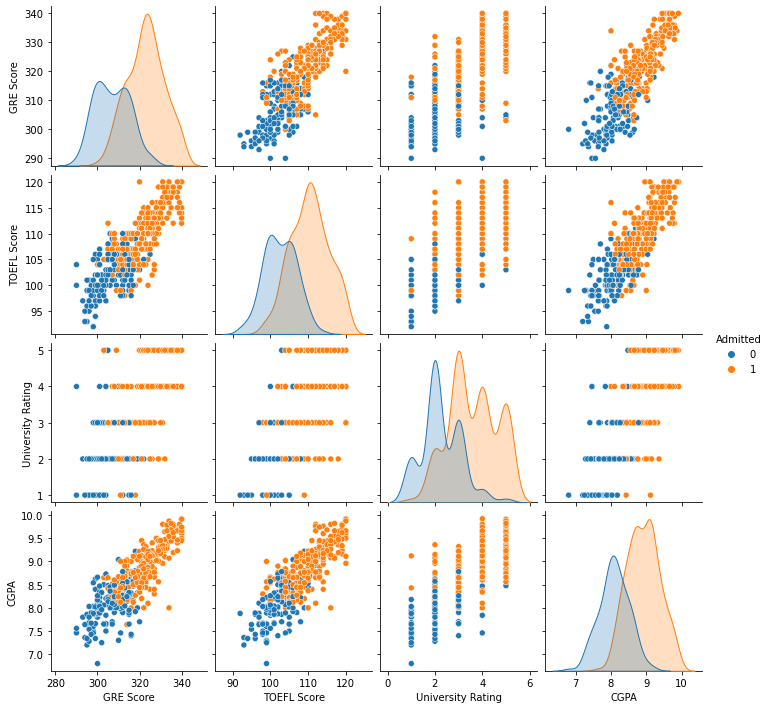

In [9]:
from seaborn import pairplot

pairplot(data.iloc[:,:],hue='Admitted')

# Offline classification

In [10]:
train_batch=data

x_train,y_train=split_attr_label(train_batch)

ridge_class=RidgeClassifier().fit(x_train,y_train)
print("ridge",ridge_class.score(x_train,y_train))

perc=Perceptron().fit(x_train,y_train)
print("perceptron :",perc.score(x_train,y_train))

x_train=normalize_data(x_train)
lr=LogisticRegressionCV(cv=5).fit(x_train,y_train)
print("cross_val :",lr.score(x_train,y_train))

ridge 0.845
perceptron : 0.6175
cross_val : 0.8475


# Online classification functions

In [11]:
def policy(pi, x):
    return pi.predict(x.values[np.newaxis,:])

def deploy_policy(x_train,y_train):
    return LogisticRegression().fit(x_train,y_train)

def misclassification_loss(x_train,y_train, pi):
    return 1-pi.score(x_train,y_train)

def fusion_batches(x,y):
    
    full_x=x[0]
    full_y=y[0]

    for id_batch in range(len(x)-1):
        
        full_x=full_x.append(x[id_batch+1],True)
        full_y=full_y.append(y[id_batch+1],True)
    
    return full_x, full_y

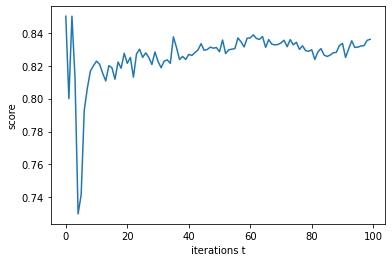

In [12]:
data=pd.read_csv("kaggle_data/Admission_Predict.csv")
data["Admitted"]=np.where(data["Chance of Admit"]>0.69,1,0)
data.drop(["Serial No.","Chance of Admit","SOP", "LOR", "Research"],inplace=True, axis=1)

batch_size=20
Tmax=100

def online_batch_classifier(data,Tmax=Tmax,batch_size=batch_size):
    
    whole_batch=None
    score=[]
    
    for t in range(Tmax):
    
        batch=sampling(data,batch_size) # environment chooses a batch
        
        if t==0:
            whole_batch=batch
        else:
            whole_batch=whole_batch.append(batch,True)
        
            
        x,y=split_attr_label(whole_batch)
        pi=LogisticRegressionCV(cv=min(batch_size,5)).fit(x,y)
        score.append(pi.score(x,y))
        
    return score

score_online=online_batch_classifier(data)
plt.xlabel('Iterations t')
plt.ylabel('Score')
plt.plot(score_online)

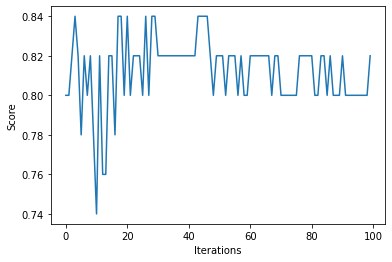

In [63]:
from sklearn.linear_model import SGDClassifier

data=pd.read_csv("kaggle_data/Admission_Predict.csv")
data["Admitted"]=np.where(data["Chance of Admit"]>0.69,1,0)
data.drop(["Serial No.","Chance of Admit","SOP", "LOR", "Research"],inplace=True, axis=1)

batch_size=20
Tmax=100
alpha=10


def online_batch_classifier(data,Tmax=Tmax,batch_size=batch_size):
    
    score=[]
    test=sampling(data,50)
    x_test,y_test=split_attr_label(test)
    x_test=normalize_data(x_test)
    pi=SGDClassifier(loss='log',alpha=0.01)
    
    for t in range(Tmax):
    
        batch=sampling(data.iloc[:350],batch_size) # environment chooses a batch
            
        x,y=split_attr_label(batch)
        x=normalize_data(x)
        pi.partial_fit(x,y,classes=[0,1])
        score.append(pi.score(x_test,y_test))
        
    return score

score_online=online_batch_classifier(data)
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.plot(score_online)
plt.show()

# Fair Functions

In [14]:
def d(x1,x2):
    return np.linalg.norm(x1-x2)/5

def is_fair(x1,x2,pi):
    return np.abs(policy(pi,x1)-policy(pi,x2)) <= d(x1,x2) +  alpha

def audit(data,pi):
    count=0
    fair=True
    for (ind1,ind2) in list(combinations(data.index,2)):
        if not (is_fair(data.loc[ind1],data.loc[ind2],pi)):
            count+=1
            if fair:
                fair=False
                rho1=ind1
                rho2=ind2
    if fair:
        return None, count
    else:
        return rho1, rho2, count
    
def audit2(data,pi):
    unfair_pairs=[]
    for (ind1,ind2) in list(combinations(data.index,2)):
        if not (is_fair(data.loc[ind1],data.loc[ind2],pi)):
            unfair_pairs.append((ind1,ind2))
    if len(unfair_pairs)==0:
        return None, len(unfair_pairs)
    else:
        ind=np.random.randint(len(unfair_pairs))
        pair=unfair_pairs[ind]
        return pair[0], pair[1], len(unfair_pairs)
    
def unfair_loss(data,pi):
    count=0
    for (ind1,ind2) in list(combinations(data.index,2)):
        if not (is_fair(data.loc[ind1],data.loc[ind2],pi)):
            count+=1
    return count/comb(len(data.index),2)

def lagrangian_loss(x_train,y_train,auditor,pi):
    mis=np.sum(np.abs(pi.predict(x_train)-y_train))
    unf=0
    if auditor[0] is not None:
        x1=x_train.loc[auditor[0]]
        x2=x_train.loc[auditor[1]]
        unf=C*(np.abs(policy(pi,x1)-policy(pi,x2))-alpha)
    return mis+unf

def add_copies(batch,C,auditor,raw_data):
    if auditor[0]:
        ind1=auditor[0]
        ind2=auditor[1]
        x_rho1=batch.loc[ind1].copy()
        x_rho2=batch.loc[ind2].copy()
        x_rho1["Admitted"]=0
        x_rho2["Admitted"]=1
        for i in range(C):
            batch=batch.append(x_rho1,True)
            raw_data=raw_data.append(x_rho1,True)
        for i in range(C):
            batch=batch.append(x_rho2,True)
            raw_data=raw_data.append(x_rho2,True)
    else:
        ind=np.random.randint(len(batch.index))
        v=batch.iloc[ind].copy()
        v["Admitted"]=0
        for i in range(C):
            batch=batch.append(v,True)
            raw_data=raw_data.append(v,True)
        v["Admitted"]=1
        for i in range(C):
            batch=batch.append(v,True)
            raw_data=raw_data.append(v,True)
    return batch,raw_data

# Online batch classification

In [15]:
data=pd.read_csv("kaggle_data/Admission_Predict.csv")
data["Admitted"]=np.where(data["Chance of Admit"]>0.69,1,0)
data.drop(["Serial No.","Chance of Admit","SOP", "LOR", "Research"],inplace=True, axis=1)



def batch_classifier(pi_fair,x,y):

    pi=[0]*(Tmax+1)
    pi[0]=pi_fair[t]

    mis=np.zeros((Tmax,))

    for step in range(len(x)):

        pi[step+1]=deploy_policy(x[step],y[step]) # deploy next policy
    
    return pi[len(x)]



### resampling from the whole previous batches
def batch_classifier2(pi_fair, x, y):
    
    x,y=fusion_batches(x,y)
    print(x.shape)
    
    inds=np.sort(rd.choice(x.index, batch_size, False))
    
    x_sampling=x.take(inds)
    y_sampling=y.take(inds)
    
    pi=[0]*(Tmax+1)
    pi[0]=pi_fair[t]

    mis=np.zeros((Tmax,))

    for step in range(Tmax):

        pi[step+1]=deploy_policy(x_train,y_train) # deploy next policy
    
    return pi[Tmax]


def batch_classifier_final(pi_bar,x_bar,y_bar, size=batch_size):
    
    x,y=fusion_batches(x_bar,y_bar)
    pi=SGDClassifier(loss='log')
    
    for t in range(Tmax):
        inds=rd.choice(x.index, size , False)
        
        pi.partial_fit(x.iloc[inds], y.iloc[inds], classes=[0,1])
    
    return pi
    


### to be completed
def context_FTPL(pi_fair,x_bars,y_bars,eps=0.5):
    
    pi=[0]*(Tmax+1)
    pi[0]=pi_fair[t]
    
    for step in range(len(x_bars)):
        
        x=x_bars[step]
        y=y_bars[step]
        
        ind=np.random.randint(len(x.index),size=k)
        samples=x.iloc[ind]
        labels=y.iloc[ind]
        lap=laplace.rvs(0,1/eps,k)
    
    return deploy_policy(samples,labels)


# Reduction from online fair batch classification to online batch classification

In [69]:
data=pd.read_csv("kaggle_data/Admission_Predict.csv")
data["Admitted"]=np.where(data["Chance of Admit"]>0.69,1,0)
data.drop(["Serial No.","Chance of Admit","SOP", "LOR", "Research"],inplace=True, axis=1)

batch_size=20
alpha=1
Tmax=100
np.set_printoptions(precision=2)
C=5
k=10

pi_fair=[0]*(Tmax+1)
x_bar_prime=[0]*(Tmax+1)
y_bar_prime=[0]*(Tmax+1)

test_batch=data.iloc[350:]
x_test,y_test=split_attr_label(test_batch)
x_test=normalize_data(x_test) 

data=data.iloc[:350]

# first arbitrary policy used
train_batch=sampling(data,10)
x_train,y_train=split_attr_label(train_batch)
x_train=normalize_data(x_train)    
pi_fair[0]=SGDClassifier(loss='log',alpha=1/Tmax).partial_fit(x_train,y_train,classes=[0,1])

mis=np.zeros((Tmax,))
unf=np.zeros((Tmax,))
lagrangian=np.zeros((Tmax,))

for t in range(Tmax):
    
    batch=sampling(data,batch_size) # environment chooses a batch
    x_train,y_train=split_attr_label(batch)
    x_train=normalize_data(x_train)

    # auditing
    auditor=audit2(x_train,pi_fair[t])
#     print("step",t,"pair", auditor)


    mis[t]=1-misclassification_loss(x_test,y_test,pi_fair[t])
    unf[t]=unfair_loss(x_test,pi_fair[t])

    
    # add copies
    batch_prime,data=add_copies(batch,C,auditor,data)
    x_train,y_train=split_attr_label(batch_prime)
    x_train=normalize_data(x_train)
    
    # store the values of the x bar prime and y bar prime
    x_bar_prime[t]=x_train
    y_bar_prime[t]=y_train
    
#     mis[t]=misclassification_loss(x_train,y_train,pi_fair[t])
#     unf[t]=unfair_loss(x_train,pi_fair[t])
    
#     pi_fair[t+1]=context_FTPL(pi_fair[:t+1],x_bar_prime[:t+1],y_bar_prime[:t+1])
#     pi_fair[t+1]=batch_classifier(pi_fair[:t+1],x_bar_prime[:t+1],y_bar_prime[:t+1])
    pi_fair[t+1]=batch_classifier_final(pi_fair[:t+1],x_bar_prime[:t+1],y_bar_prime[:t+1])

    
    
print("misclassification loss",np.mean(mis), np.std(mis))
print("unfair",np.mean(unf),np.std(unf))
print("lagrangian loss",lagrangian,np.mean(lagrangian), np.std(lagrangian))

misclassification loss 0.7080000000000003 0.23222402976436354
unfair 0.0 0.0
lagrangian loss [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] 0.0 0.0


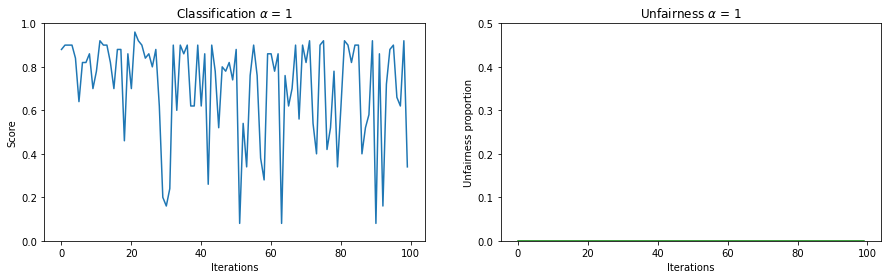

In [70]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

ax[0].set_title(r'Classification $\alpha$ = {}'.format(alpha))
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].plot(mis)

ax[1].set_title(r'Unfairness $\alpha$ = {}'.format(alpha))
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Unfairness proportion')
ax[1].set_ylim([0,0.5])
ax[1].plot(unf, color='g')

In [18]:
# x_test,y_test=split_attr_label(data)

# for pi in pi_fair: 
#     print(misclassification_loss(x_test, y_test, pi))

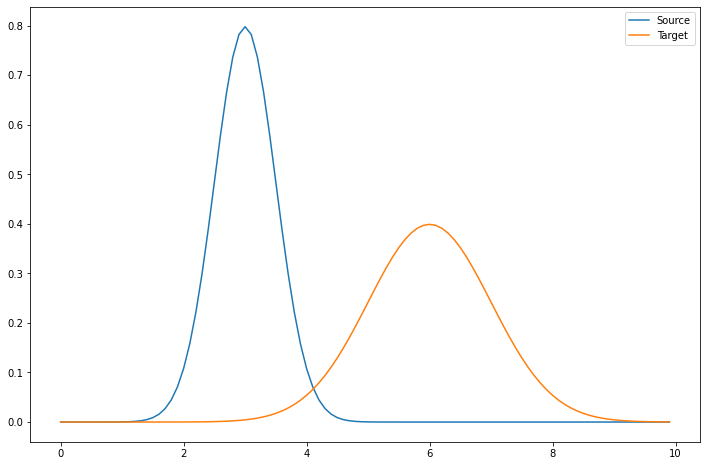

In [19]:
import scipy.stats as ss


x=np.arange(0,10,0.1)
pdf_source=ss.norm(3,0.5).pdf(x)
pdf_target=ss.norm(6,1).pdf(x)

plt.figure(figsize=(12,8))
plt.plot(x,pdf_source,label='Source')
plt.plot(x,pdf_target,label='Target')
plt.legend()
plt.show()